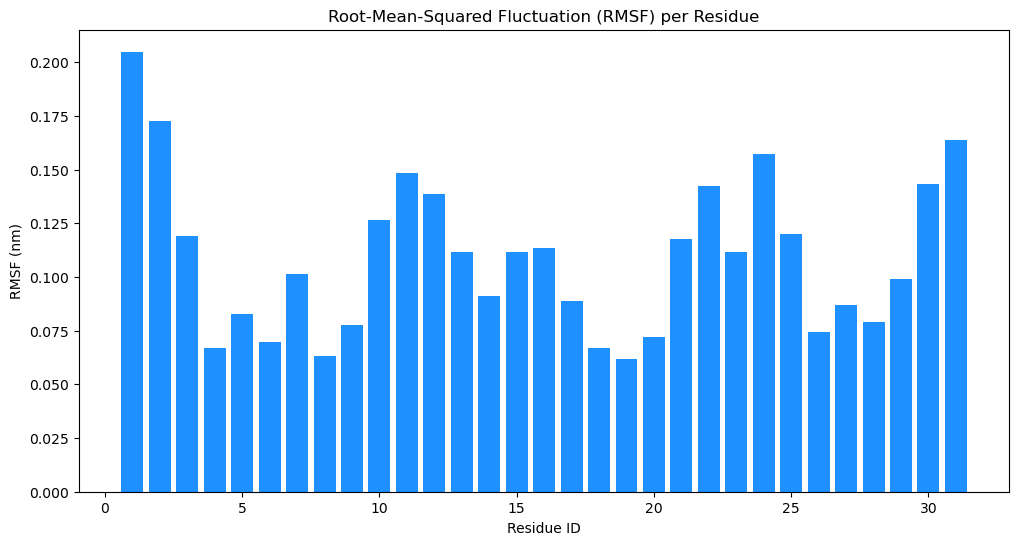

In [8]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import glob

# Step 1: Load all .pdb files in the folder
pdb_files = sorted(glob.glob('*.pdb'))  # Adjust the path to your folder
trajectories = [md.load(pdb) for pdb in pdb_files]

# Step 2: Use the first structure as the reference for alignment
reference_traj = trajectories[0]  # Use the first PDB file as the reference

# Step 3: Superimpose and slice all trajectories to the reference structure's backbone atoms
aligned_trajs = []
backbone_selection = reference_traj.topology.select('backbone')  # Select backbone atoms

for traj in trajectories:
    aligned_traj = traj.superpose(reference_traj, atom_indices=backbone_selection)
    aligned_trajs.append(aligned_traj)

# Step 4: Find common atoms between reference and AlphaFold models
ref_topology = reference_traj.topology
af_topology = aligned_trajs[0].topology  # Using the first aligned AlphaFold model for comparison

# Use backbone atoms for comparison
ref_backbone_indices = ref_topology.select('backbone')
af_backbone_indices = af_topology.select('backbone')

# Step 5: Align and slice all trajectories to the common backbone atoms
common_trajs = []
for traj in aligned_trajs:
    # Align using the backbone atoms
    traj.superpose(reference_traj, atom_indices=af_backbone_indices)
    # Slice to include only backbone atoms present in both
    common_traj = traj.atom_slice(af_backbone_indices)
    # Strip unit cell information to avoid errors
    common_traj.unitcell_vectors = None
    common_trajs.append(common_traj)

# Step 6: Concatenate trajectories (disabling topology check)
combined_traj = md.join(common_trajs, check_topology=False)

# Step 7: Compute RMSF (root-mean-squared fluctuation) for each residue's alpha carbon atoms
ca_indices = combined_traj.topology.select('name CA')  # Select alpha carbons
mean_structure = combined_traj.xyz.mean(axis=0)  # Mean structure of all frames
rmsf = np.sqrt(((combined_traj.xyz[:, ca_indices, :] - mean_structure[ca_indices])**2).mean(axis=(0, 2)))

# Step 8: Plot RMSF vs. Residue ID
residue_ids = [residue.index + 1 for residue in combined_traj.topology.residues if residue.name != 'HOH']  # Exclude water residues
plt.figure(figsize=(12, 6))
plt.bar(residue_ids, rmsf, color='dodgerblue')
plt.xlabel('Residue ID')
plt.ylabel('RMSF (nm)')
plt.title('Root-Mean-Squared Fluctuation (RMSF) per Residue')
plt.show()

